## 3.1. Preprocessor for SIFT feature target generator

In [1]:
import time

import numpy as np
import tensorflow as tf
import tensorpack as tp

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

### 3.1.1. Tensorpack dataflow test

In [2]:
from tensorpack.dataflow import *

class SampleList(RNGDataFlow):
    def __init__(self, shuffle=False, detector = cv2.xfeatures2d.SIFT_create()):
        self.filelist = [
            ('datas/yosemite_test/yosemite1.jpg', 1),
            ('datas/yosemite_test/yosemite2.jpg', 2),
            ('datas/yosemite_test/yosemite3.jpg', 3),
            ('datas/yosemite_test/yosemite4.jpg', 4),
        ]
        self.shuffle = shuffle
        self.detector = detector
        
    def size(self):
        return len(self.filelist)
    
    def preprocessing(self, filename):
        image = cv2.imread(filename)
        shape = image.shape[:2]
        
        keypoints = self.detector.detect(cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2GRAY))
        return [image,] + SampleList.convertKeypoints2Features(keypoints)
        
    def get_data(self):
        idxs = np.arange(len(self.filelist))
        if self.shuffle:
            self.rng.shuffle(idxs)
        for k in idxs:
            filename, label = self.filelist[k]
            yield self.preprocessing(filename)
            
    @staticmethod
    def convertKeypoints2Features(keypoints):
        features_point = []
        features_direction = []
        for kp in keypoints:
            point = np.array(kp.pt)
            theta = np.radians(kp.angle)
            size = kp.size
            
            c, s = np.cos(theta), np.sin(theta)
            R = np.array(((c, -s), (s, c))).T
            target = point + (np.matmul(np.array((1.0, 0.0)), R) * size)
            features_point.append( point )
            features_direction.append( target )
        responses = [kp.response for kp in keypoints] # 0~1
        return [np.array(features_point), np.array(features_direction), responses]
    
    @staticmethod
    def convertFeatures2Keypoints(points, directions, responses):
        keypoints = []
        for point, direction, response in zip(points, directions, responses):
            target = direction - point
            size = np.linalg.norm(target)
            
            theta = np.arccos( np.dot(np.array((1.0, 0.0)), (target/size)) )
            if target[1] >= 0:
                angle = np.degrees(theta)
            else:
                angle = np.pi + np.degrees(-theta)
                
            kp = cv2.KeyPoint(point[0], point[1], size, angle, response)
            keypoints.append( kp )
        return keypoints
    
    @staticmethod
    def convertKeypoints2Map(shape, keypoints):
        feature = np.zeros( shape[:2] + (3,) )
        for kp in keypoints:
            x = int(kp.pt[0]+0.5)
            y = int(kp.pt[1]+0.5)
            if feature[y][x][0] < kp.response:
                feature[y][x][0] = kp.response
                feature[y][x][1] = kp.size / 100.0
                feature[y][x][2] = kp.angle / 360.0
        return feature
    
    @staticmethod
    def convertMap2Keypoints(feature_map):
        shape = feature_map.shape
        keypoints = []
        for y in range(shape[0]):
            for x in range(shape[1]):
                if feature_map[y][x][0] > 1e-9:
                    f = feature_map[y][x]
                    kp = cv2.KeyPoint(x, y, f[1]*100.0, f[2]*360.0, f[0])
                    keypoints.append( kp )
        return keypoints

ds = SampleList()
ds = BatchData(ds, 2, use_list=True)
ds = PrintData(ds, num=2)
TestDataSpeed(ds, size=2).start()

  0%|          |0/2[00:00<?,?it/s]

[1105 23:09:35 @common.py:726] DataFlow Info:
datapoint 0<2 with 4 components consists of
   is list of 2 elements
   is list of 2 elements
   is list of 2 elements
   is list of 2 elements


100%|##########|2/2[00:00<00:00, 3.41it/s]

datapoint 1<2 with 4 components consists of
   is list of 2 elements
   is list of 2 elements
   is list of 2 elements
   is list of 2 elements


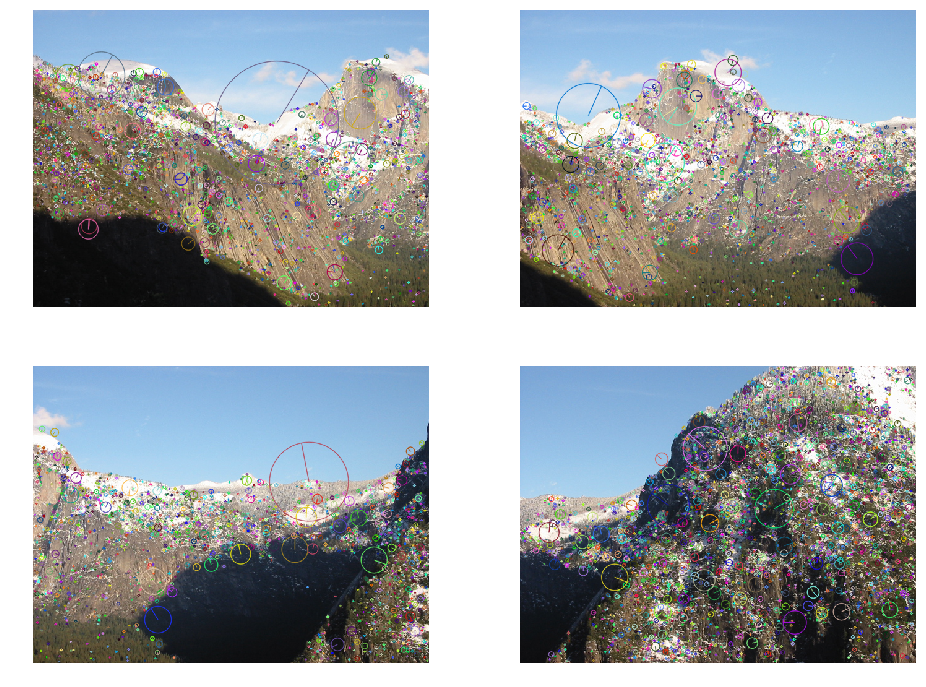

In [3]:
ds = SampleList()

def draw(ax, image, keypoints):
    result = cv2.drawKeypoints(image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    ax.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    _ = ax.axis("off")

fig = plt.figure(figsize=(16, 12))
i = 0
for data in ds.get_data():
    image, feature = data[0], data[1:]
    keypoints = SampleList.convertFeatures2Keypoints(*feature)
    
    ax = fig.add_subplot(2, 2, i+1)
    draw(ax, image, keypoints)
    i+=1

### 3.1.2. Tensorpack image augmented test

In [4]:
ds = SampleList()
augs = [
    imgaug.RandomResize((0.9, 1.2), (0.9, 1.2)),
    imgaug.Rotation(45, center_range=(0.4, 0.6)),
    
    imgaug.RandomChooseAug([
        imgaug.SaltPepperNoise(white_prob=0.01, black_prob=0.01),
        imgaug.RandomOrderAug([
            imgaug.BrightnessScale((0.8, 1.2), clip=False),
            imgaug.Contrast((0.8, 1.2), clip=False),
            imgaug.Saturation(0.4, rgb=True),
        ]),
    ]), 
    imgaug.ResizeShortestEdge(400),
    imgaug.RandomCrop((250, 250)),        
    imgaug.Flip(horiz=True, prob=0.5),
    imgaug.Flip(vert=True, prob=0.5),
]
ds_aug = tp.AugmentImageComponents(ds, augs, index=(0,), coords_index=(1,2,))


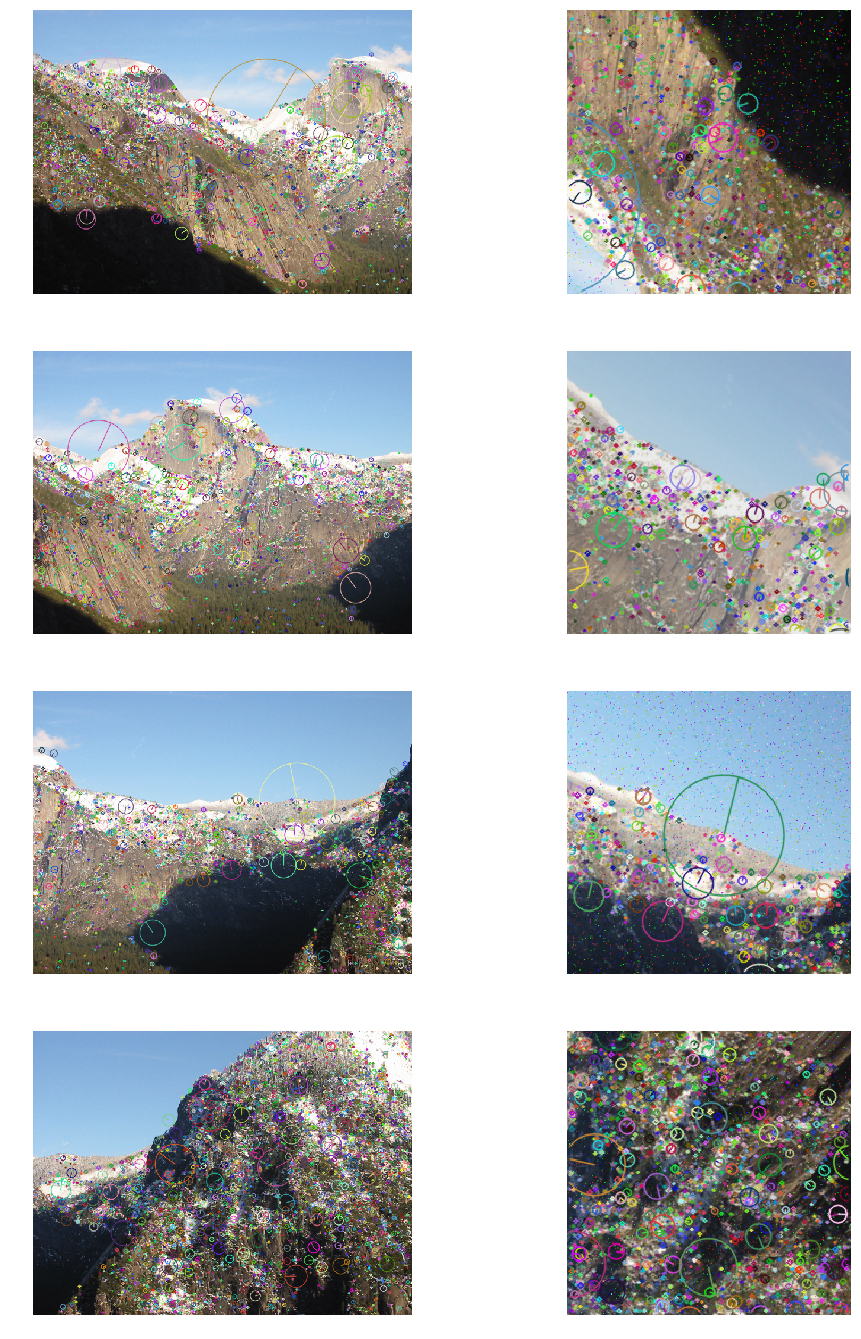

In [5]:
fig = plt.figure(figsize=(16, 12*2))
i = 0
for origin, augmented in zip(ds.get_data(), ds_aug.get_data()):
    image, feature = origin[0], origin[1:]
    keypoints = SampleList.convertFeatures2Keypoints(*feature)
    ax = fig.add_subplot(4, 2, i*2+1)
    draw(ax, image, keypoints)

    image, feature = augmented[0], augmented[1:]
    keypoints = SampleList.convertFeatures2Keypoints(*feature)
    ax = fig.add_subplot(4, 2, i*2+2)
    draw(ax, image, keypoints)

    i+=1

### 3.1.3. feature map test

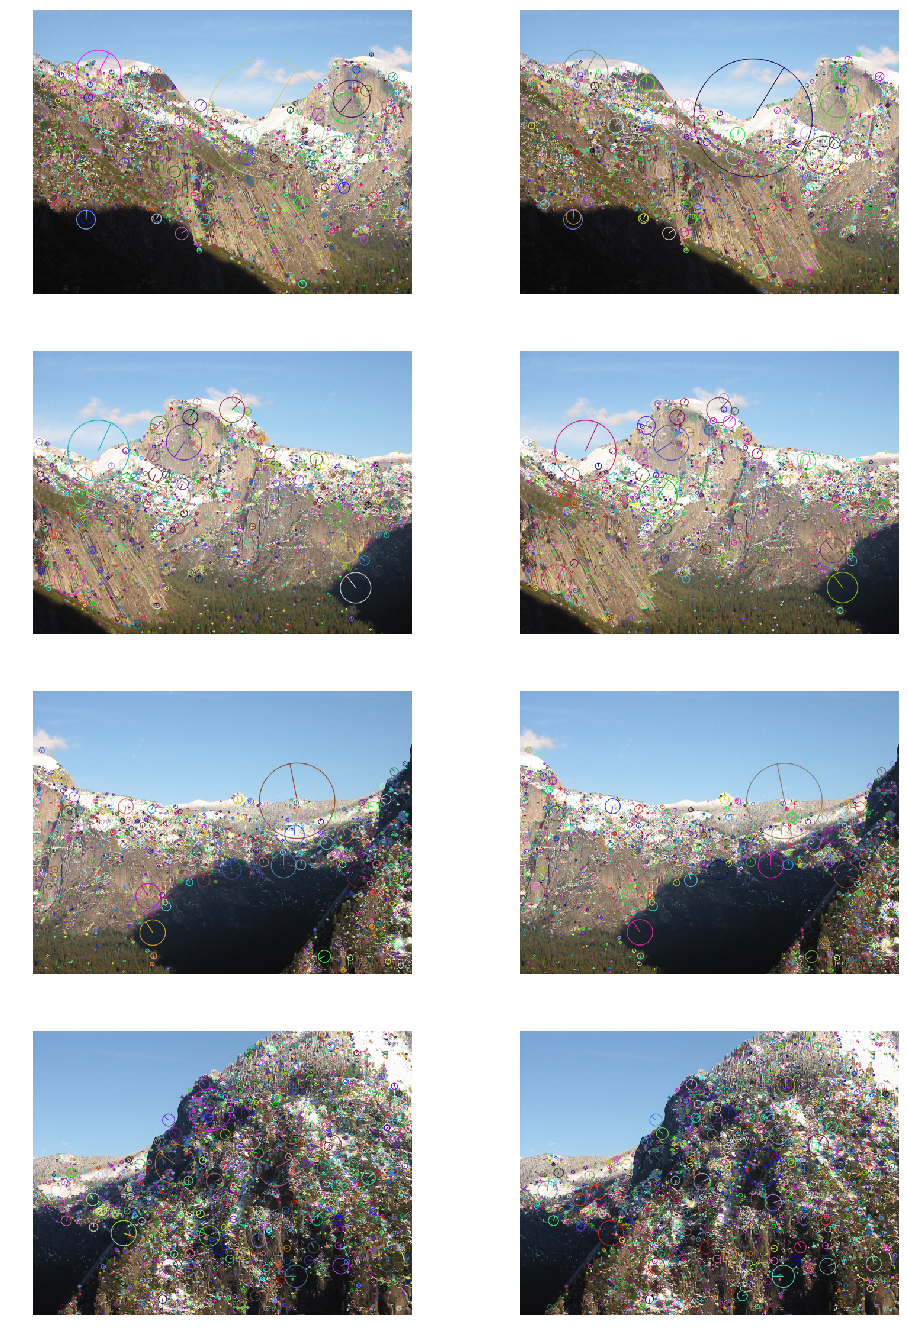

In [6]:
fig = plt.figure(figsize=(16, 12*2))
i = 0
for origin in ds.get_data():
    image, feature = origin[0], origin[1:]
    keypoints = SampleList.convertFeatures2Keypoints(*feature)
    ax = fig.add_subplot(4, 2, i*2+1)
    draw(ax, image, keypoints)

    feature_map = SampleList.convertKeypoints2Map(image.shape[:2], keypoints)
    keypoints = SampleList.convertMap2Keypoints(feature_map)
    ax = fig.add_subplot(4, 2, i*2+2)
    draw(ax, image, keypoints)

    i+=1